In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pickle
import pandas as pd
import glob
from run import OUTPUT_DIR

/Users/theodoraboulouta/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/theodoraboulouta/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using M1 Mac


In [2]:
print(OUTPUT_DIR)

full_mnist_cpu_no_gss


In [3]:
import glob
import pickle
import pandas as pd
import os

def load_results():
    results = []
    for fname in glob.glob(f'{OUTPUT_DIR}/*/*'):
        # print('Reading from {}'.format(fname))
        if os.path.splitext(fname)[1] == '.pickle':  # Only try to unpickle .pickle files
            try:
                with open(fname, 'rb') as f:
                    result = pickle.load(f)
                    results.append(result)
            except (pickle.UnpicklingError, EOFError, AttributeError) as e:
                print(f"Error unpickling {fname}: {str(e)}")
        # else:
        #     print(f"Skipping non-pickle file: {fname}")
    
    df = pd.DataFrame(results)
    return df

results = load_results()

In [10]:

def get_metric(df, p_val, method, metric):
    #returns the average and std for a given metric 
    p_value_df = df[df["p"] == p_val].reset_index(drop=True)
    method_metrics = p_value_df[method]
    metric_values = []
    for i in range(0, len(method_metrics)):         
         if metric == "Accuracy":
            metric_values.append(method_metrics[i]['M3 per task performance'][4])

         if metric == "M2 similarity":
             metric_values.append(method_metrics[i]['gradient similarities']['M2'])

         if metric == "M1 similarity":
             metric_values.append(method_metrics[i]['gradient similarities']['M1'])
             
    return metric_values

def get_metric_stats(metric_values):
    return np.average(metric_values), np.std(metric_values)


metrics = get_metric(results, 0.01, "RandomMemorySetManager memory selection", "Accuracy")
get_metric_stats(metrics)


(0.984367120524458, 0.0037871877671242634)

In [11]:


def aggregate_results(results):
    methods = [
        "RandomMemorySetManager memory selection",
        "KMeansMemorySetManager memory selection",
        "LambdaMemorySetManager memory selection",
        "iCaRL memory selection (icarl)",
        "iCaRL memory selection (replay)"
    ]
    method_names = ["Random", "KMeans", "Lambda", 'icarl', 'icarl replay']
    metrics = ["Accuracy", "M1 similarity", "M2 similarity"]
    
    unique_p_values = results['p'].unique()
    
    processed_data = []
    
    for p in unique_p_values:
        for method, method_name in zip(methods, method_names):
            filtered_data = results[(results['p'] == p) & (results[method].notna())]
            
            if not filtered_data.empty:
                row_data = {
                    'p': p,
                    'method': method_name,
                    'samples': len(filtered_data)
                }
                
                for metric in metrics:
                    metric_values = get_metric(filtered_data, p, method, metric)
                    avg, std = get_metric_stats(metric_values)
                    
                    if metric == "Accuracy":
                        row_data['M3_task4_avg'] = avg
                        row_data['M3_task4_std'] = std
                    elif metric == "M1 similarity":
                        row_data['M1_grad_sim_avg'] = avg
                        row_data['M1_grad_sim_std'] = std
                    elif metric == "M2 similarity":
                        row_data['M2_grad_sim_avg'] = avg
                        row_data['M2_grad_sim_std'] = std
                
                processed_data.append(row_data)
    
    processed_df = pd.DataFrame(processed_data)
    
    return processed_df

In [12]:
aggregated_results = aggregate_results(results)
aggregated_results

,p,method,samples,M3_task4_avg,M3_task4_std,M1_grad_sim_avg,M1_grad_sim_std,M2_grad_sim_avg,M2_grad_sim_std
0,0.100,Random,5,0.987796,0.004458,0.985051,0.002432,0.975268,0.008429
1,0.100,KMeans,5,0.985880,0.004022,0.998391,0.000570,0.997755,0.000724
2,0.100,Lambda,5,0.984065,0.004737,0.999656,0.000201,0.999532,0.000188
3,0.100,icarl,5,0.986586,0.001038,0.999797,0.000114,0.999760,0.000099
4,0.100,icarl replay,5,0.981947,0.004200,0.999938,0.000030,0.999898,0.000038
5,0.002,Random,5,0.993444,0.000451,0.870924,0.066373,0.965507,0.031175
6,0.002,KMeans,5,0.992537,0.002437,0.973060,0.012676,0.986620,0.006895
7,0.002,Lambda,5,0.992133,0.001930,0.999282,0.000388,0.999275,0.000383
8,0.002,icarl,5,0.992335,0.002638,0.999538,0.000245,0.999706,0.000159
9,0.002,icarl replay,5,0.990923,0.001315,0.999676,0.000137,0.999746,0.000151


In [14]:
def aggregate_results(results):
    methods = [
        "RandomMemorySetManager memory selection",
        "KMeansMemorySetManager memory selection",
        "LambdaMemorySetManager memory selection",
        "iCaRL memory selection (icarl)",
        "iCaRL memory selection (replay)"
    ]
    method_names = ["Random", "KMeans", "Lambda", 'icarl', 'icarl replay']
    metrics = ["Accuracy", "M1 similarity", "M2 similarity"]
    
    unique_p_values = results['p'].unique()
    
    processed_data = []
    
    for p in unique_p_values:
        for method, method_name in zip(methods, method_names):
            filtered_data = results[(results['p'] == p) & (results[method].notna())]
            
            if not filtered_data.empty:
                row_data = {
                    'p': p,
                    'method': method_name,
                    'samples': len(filtered_data)
                }
                
                for metric in metrics:
                    metric_values = get_metric(filtered_data, p, method, metric)
                    avg, std = get_metric_stats(metric_values)
                    
                    if metric == "Accuracy":
                        row_data['M3_task4_avg'] = avg
                        row_data['M3_task4_std'] = std
                        row_data['M3_task4_array'] = metric_values
                    elif metric == "M1 similarity":
                        row_data['M1_grad_sim_avg'] = avg
                        row_data['M1_grad_sim_std'] = std
                        row_data['M1_grad_sim_array'] = metric_values
                    elif metric == "M2 similarity":
                        row_data['M2_grad_sim_avg'] = avg
                        row_data['M2_grad_sim_std'] = std
                        row_data['M2_grad_sim_array'] = metric_values
                
                processed_data.append(row_data)
    
    processed_df = pd.DataFrame(processed_data)
    
    return processed_df

In [15]:
aggregated_results = aggregate_results(results)
aggregated_results

,p,method,samples,M3_task4_avg,M3_task4_std,M3_task4_array,M1_grad_sim_avg,M1_grad_sim_std,M1_grad_sim_array,M2_grad_sim_avg,M2_grad_sim_std,M2_grad_sim_array
0,0.100,Random,5,0.987796,0.004458,"[0.9853756933938477, 0.9904185577407968, 0.980...",0.985051,0.002432,"[0.9844953176513108, 0.9866203027095795, 0.982...",0.975268,0.008429,"[0.9840532603224543, 0.9830823741613997, 0.977..."
1,0.100,KMeans,5,0.985880,0.004022,"[0.988905698436712, 0.9838628340897629, 0.9914...",0.998391,0.000570,"[0.998555213908706, 0.9988112660498303, 0.9983...",0.997755,0.000724,"[0.9984414305344619, 0.997810432552578, 0.9983..."
2,0.100,Lambda,5,0.984065,0.004737,"[0.983358547655068, 0.9752899646999496, 0.9868...",0.999656,0.000201,"[0.9997115244224531, 0.9993092328968461, 0.999...",0.999532,0.000188,"[0.9998610200540382, 0.999488601626982, 0.9992..."
3,0.100,icarl,5,0.986586,0.001038,"[0.9868885526979324, 0.9858799798285426, 0.988...",0.999797,0.000114,"[0.9997952348838596, 0.9996052735252754, 0.999...",0.999760,0.000099,"[0.9999438269293957, 0.9997621350874617, 0.999..."
4,0.100,icarl replay,5,0.981947,0.004200,"[0.9853756933938477, 0.9843671205244579, 0.983...",0.999938,0.000030,"[0.999934560971738, 0.9998942210263665, 0.9999...",0.999898,0.000038,"[0.9999573019890609, 0.9998457040946872, 0.999..."
5,0.002,Random,5,0.993444,0.000451,"[0.9939485627836612, 0.9939485627836612, 0.992...",0.870924,0.066373,"[0.984312054759636, 0.8560188512447444, 0.8516...",0.965507,0.031175,"[0.9703343860345109, 0.9777915693090043, 0.982..."
6,0.002,KMeans,5,0.992537,0.002437,"[0.9924357034795764, 0.9959657085224407, 0.989...",0.973060,0.012676,"[0.9899514625460871, 0.9766683979586493, 0.973...",0.986620,0.006895,"[0.981725547977454, 0.9901823270461385, 0.9915..."
7,0.002,Lambda,5,0.992133,0.001930,"[0.9909228441754917, 0.9949571356530509, 0.990...",0.999282,0.000388,"[0.9994718959464548, 0.9997841337247964, 0.998...",0.999275,0.000383,"[0.9985853192291817, 0.9991417308895298, 0.999..."
8,0.002,icarl,5,0.992335,0.002638,"[0.9934442763489663, 0.9884014120020171, 0.991...",0.999538,0.000245,"[0.999627594836131, 0.9998429087749833, 0.9992...",0.999706,0.000159,"[0.9996452066343227, 0.9994203282400457, 0.999..."
9,0.002,icarl replay,5,0.990923,0.001315,"[0.9929399899142713, 0.989409984871407, 0.9899...",0.999676,0.000137,"[0.9996872526366132, 0.9998635769123142, 0.999...",0.999746,0.000151,"[0.9997096866946019, 0.9994684343577741, 0.999..."


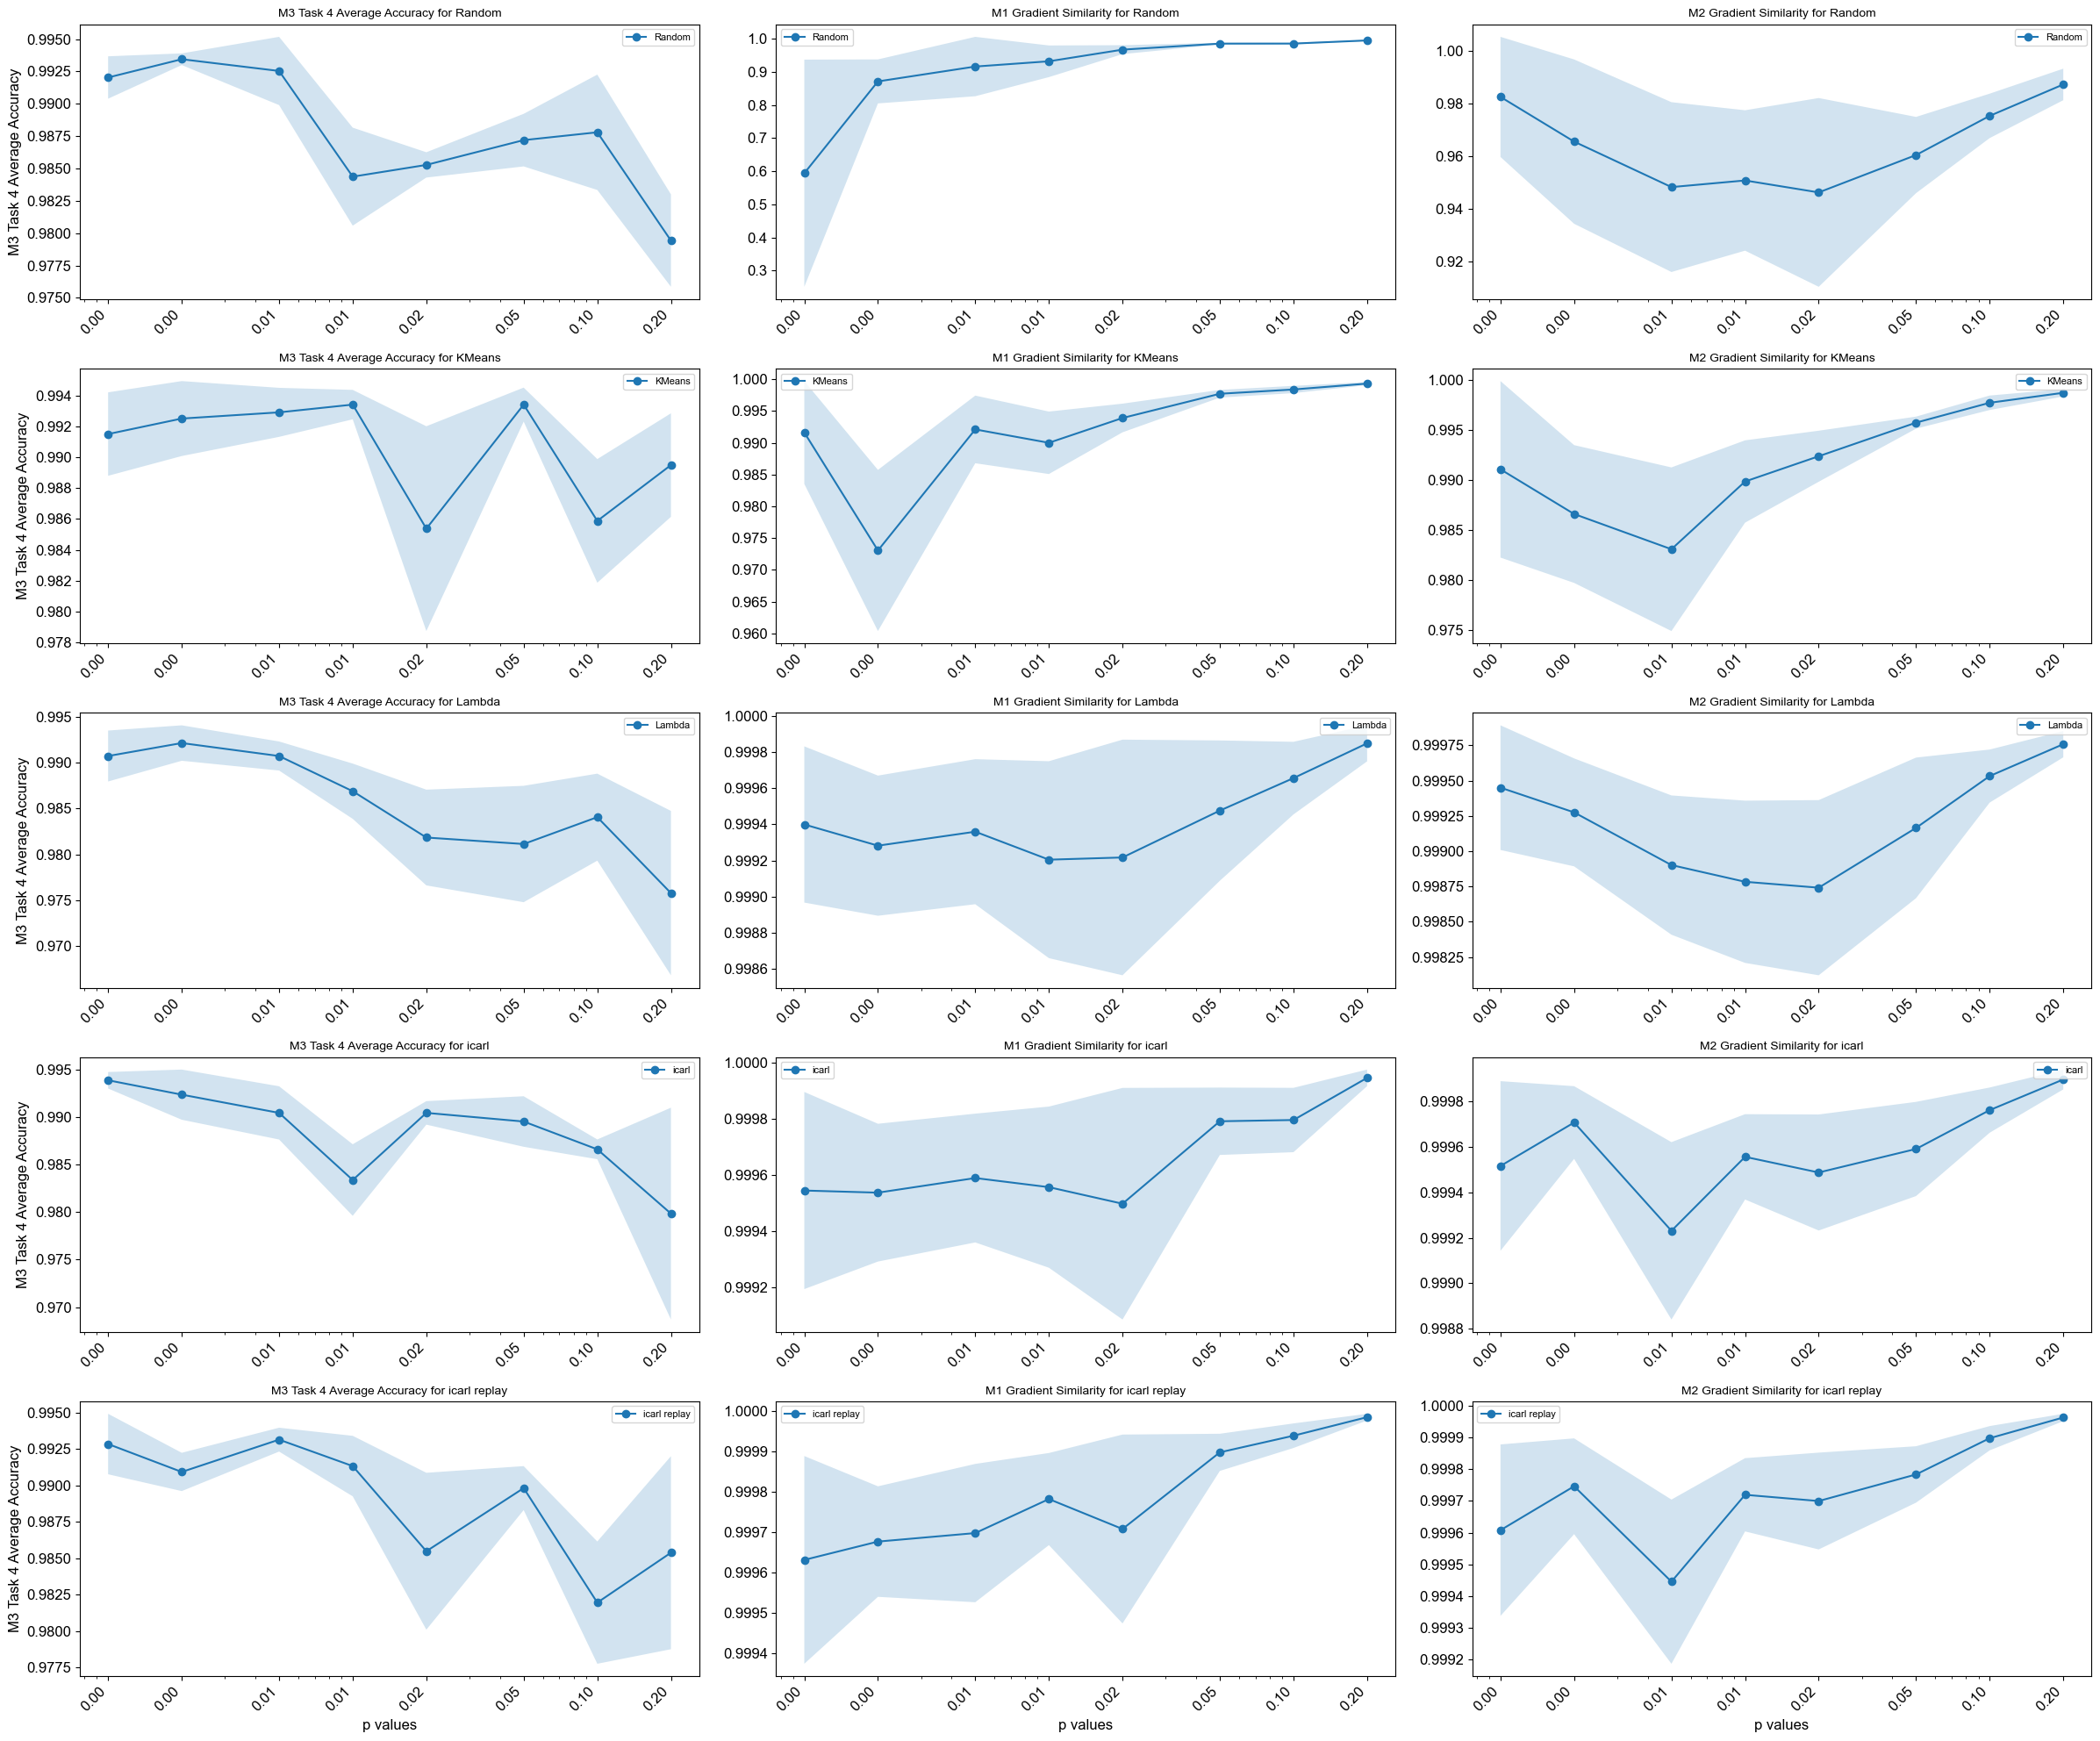

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_all_metrics(aggregated_results, dataset_name):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    methods = aggregated_results['method'].unique()
    p_vals = sorted(aggregated_results['p'].unique())
    
    num_methods = len(methods)
    fig, axs = plt.subplots(num_methods, 3, figsize=(24, 4*num_methods))
    
    metrics = ['M3_task4', 'M1_grad_sim', 'M2_grad_sim']
    titles = ['M3 Task 4 Average Accuracy', 'M1 Gradient Similarity', 'M2 Gradient Similarity']
    
    for method_index, method in enumerate(methods):
        method_data = aggregated_results[aggregated_results['method'] == method]
        
        for col, (metric, title) in enumerate(zip(metrics, titles)):
            if num_methods == 1:
                ax = axs[col]
            else:
                ax = axs[method_index, col]
            
            avg_values = [method_data[method_data['p'] == p][f'{metric}_avg'].values[0] for p in p_vals]
            std_values = [method_data[method_data['p'] == p][f'{metric}_std'].values[0] for p in p_vals]
            
            ax.plot(p_vals, avg_values, marker='o', label=method)
            ax.fill_between(p_vals, 
                            np.array(avg_values) - np.array(std_values), 
                            np.array(avg_values) + np.array(std_values), 
                            alpha=0.2)
            
            ax.set_xscale('log')
            ax.set_title(f'{title} for {method}', fontsize=10)
            ax.legend(fontsize=8)
            
            ax.set_xticks(p_vals)
            ax.set_xticklabels([f'{p:.2f}' for p in p_vals], rotation=45, ha='right')
            
            if method_index == num_methods - 1:  # Last row
                ax.set_xlabel('p values')
            
            if col == 0:  # First column
                ax.set_ylabel(title)
    
    plt.tight_layout()
    plt.savefig(f'{result_dir}/all_metrics_vs_p_subplots.png')
    plt.show()

plot_all_metrics(aggregated_results, 'dataset_name')

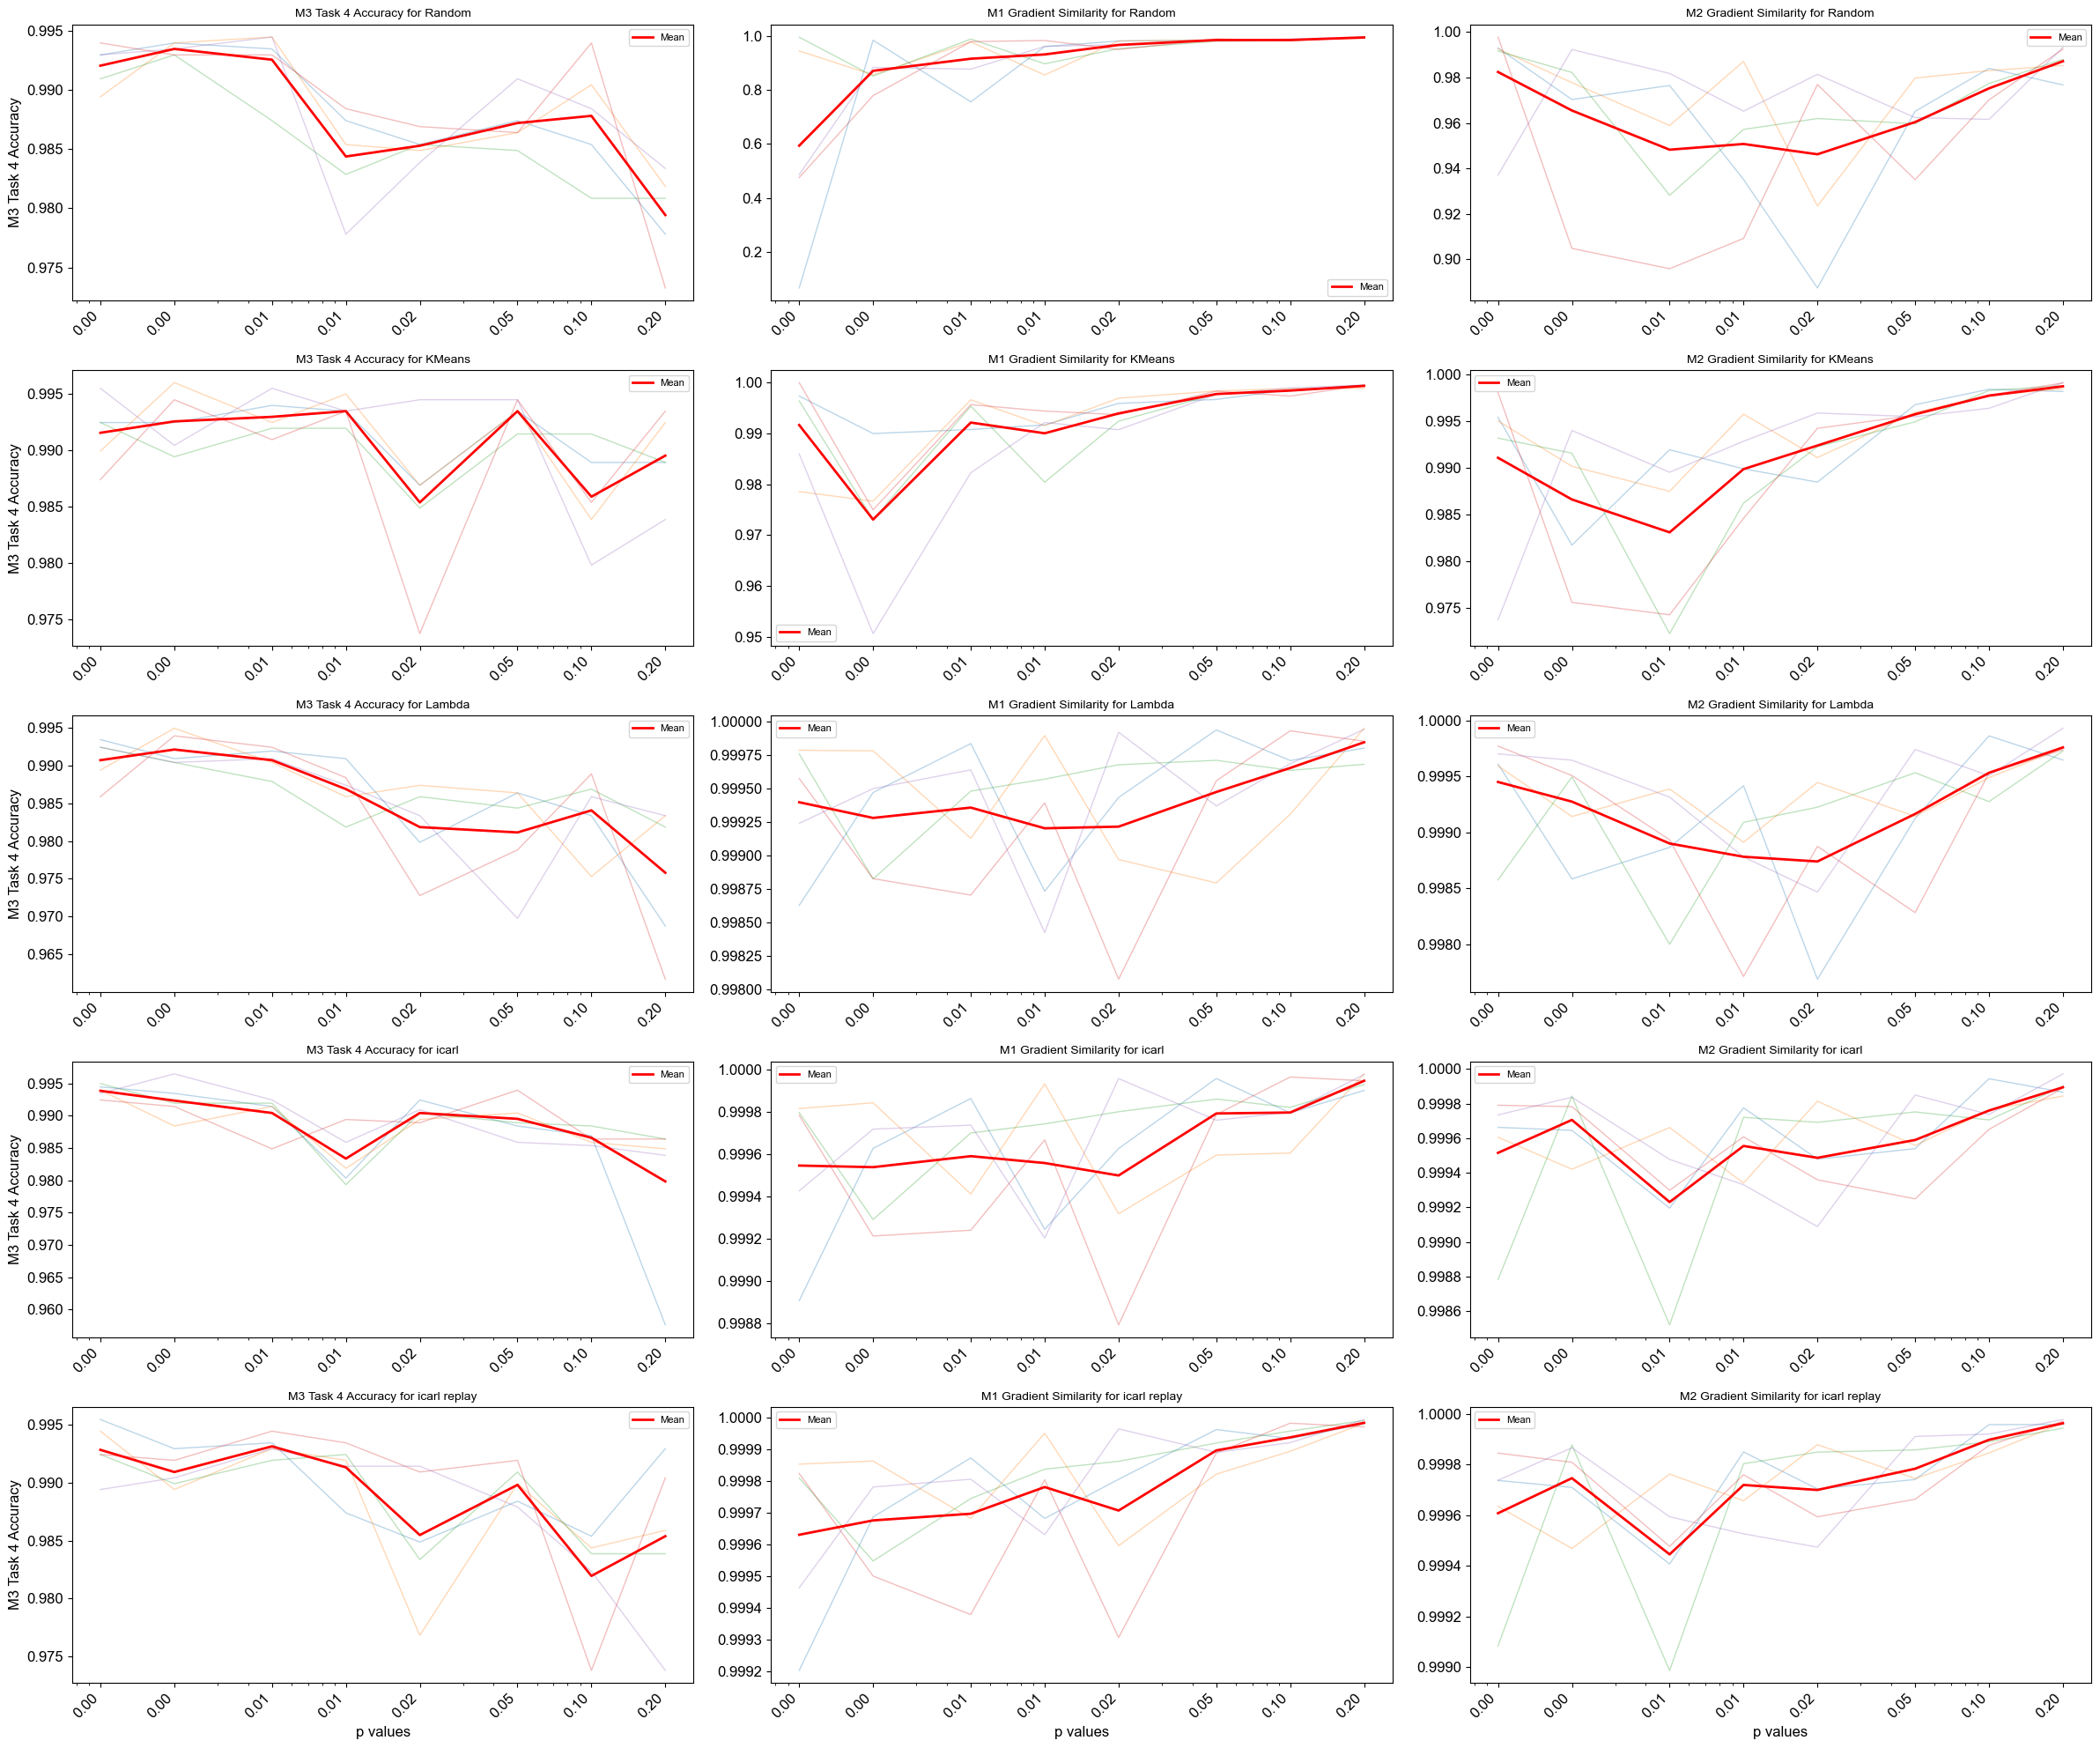

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_all_metrics(aggregated_results, dataset_name):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    methods = aggregated_results['method'].unique()
    p_vals = sorted(aggregated_results['p'].unique())
    
    num_methods = len(methods)
    fig, axs = plt.subplots(num_methods, 3, figsize=(24, 4*num_methods))
    
    metrics = ['M3_task4', 'M1_grad_sim', 'M2_grad_sim']
    titles = ['M3 Task 4 Accuracy', 'M1 Gradient Similarity', 'M2 Gradient Similarity']
    
    for method_index, method in enumerate(methods):
        method_data = aggregated_results[aggregated_results['method'] == method]
        
        for col, (metric, title) in enumerate(zip(metrics, titles)):
            if num_methods == 1:
                ax = axs[col]
            else:
                ax = axs[method_index, col]
            
            # Get the number of samples
            num_samples = len(method_data[method_data['p'] == p_vals[0]][f'{metric}_array'].values[0])
            
            for sample_index in range(num_samples):
                sample_values = [method_data[method_data['p'] == p][f'{metric}_array'].values[0][sample_index] for p in p_vals]
                ax.plot(p_vals, sample_values, alpha=0.3, linewidth=1)
            
            # Calculate and plot the mean
            mean_values = [np.mean(method_data[method_data['p'] == p][f'{metric}_array'].values[0]) for p in p_vals]
            ax.plot(p_vals, mean_values, color='red', linewidth=2, label='Mean')
            
            ax.set_xscale('log')
            ax.set_title(f'{title} for {method}', fontsize=10)
            ax.legend(fontsize=8)
            
            ax.set_xticks(p_vals)
            ax.set_xticklabels([f'{p:.2f}' for p in p_vals], rotation=45, ha='right')
            
            if method_index == num_methods - 1:  # Last row
                ax.set_xlabel('p values')
            
            if col == 0:  # First column
                ax.set_ylabel(title)
    
    plt.tight_layout()
    plt.savefig(f'{result_dir}/all_metrics_vs_p_subplots_sample_lines.png')
    plt.show()

plot_all_metrics(aggregated_results, 'dataset_name')

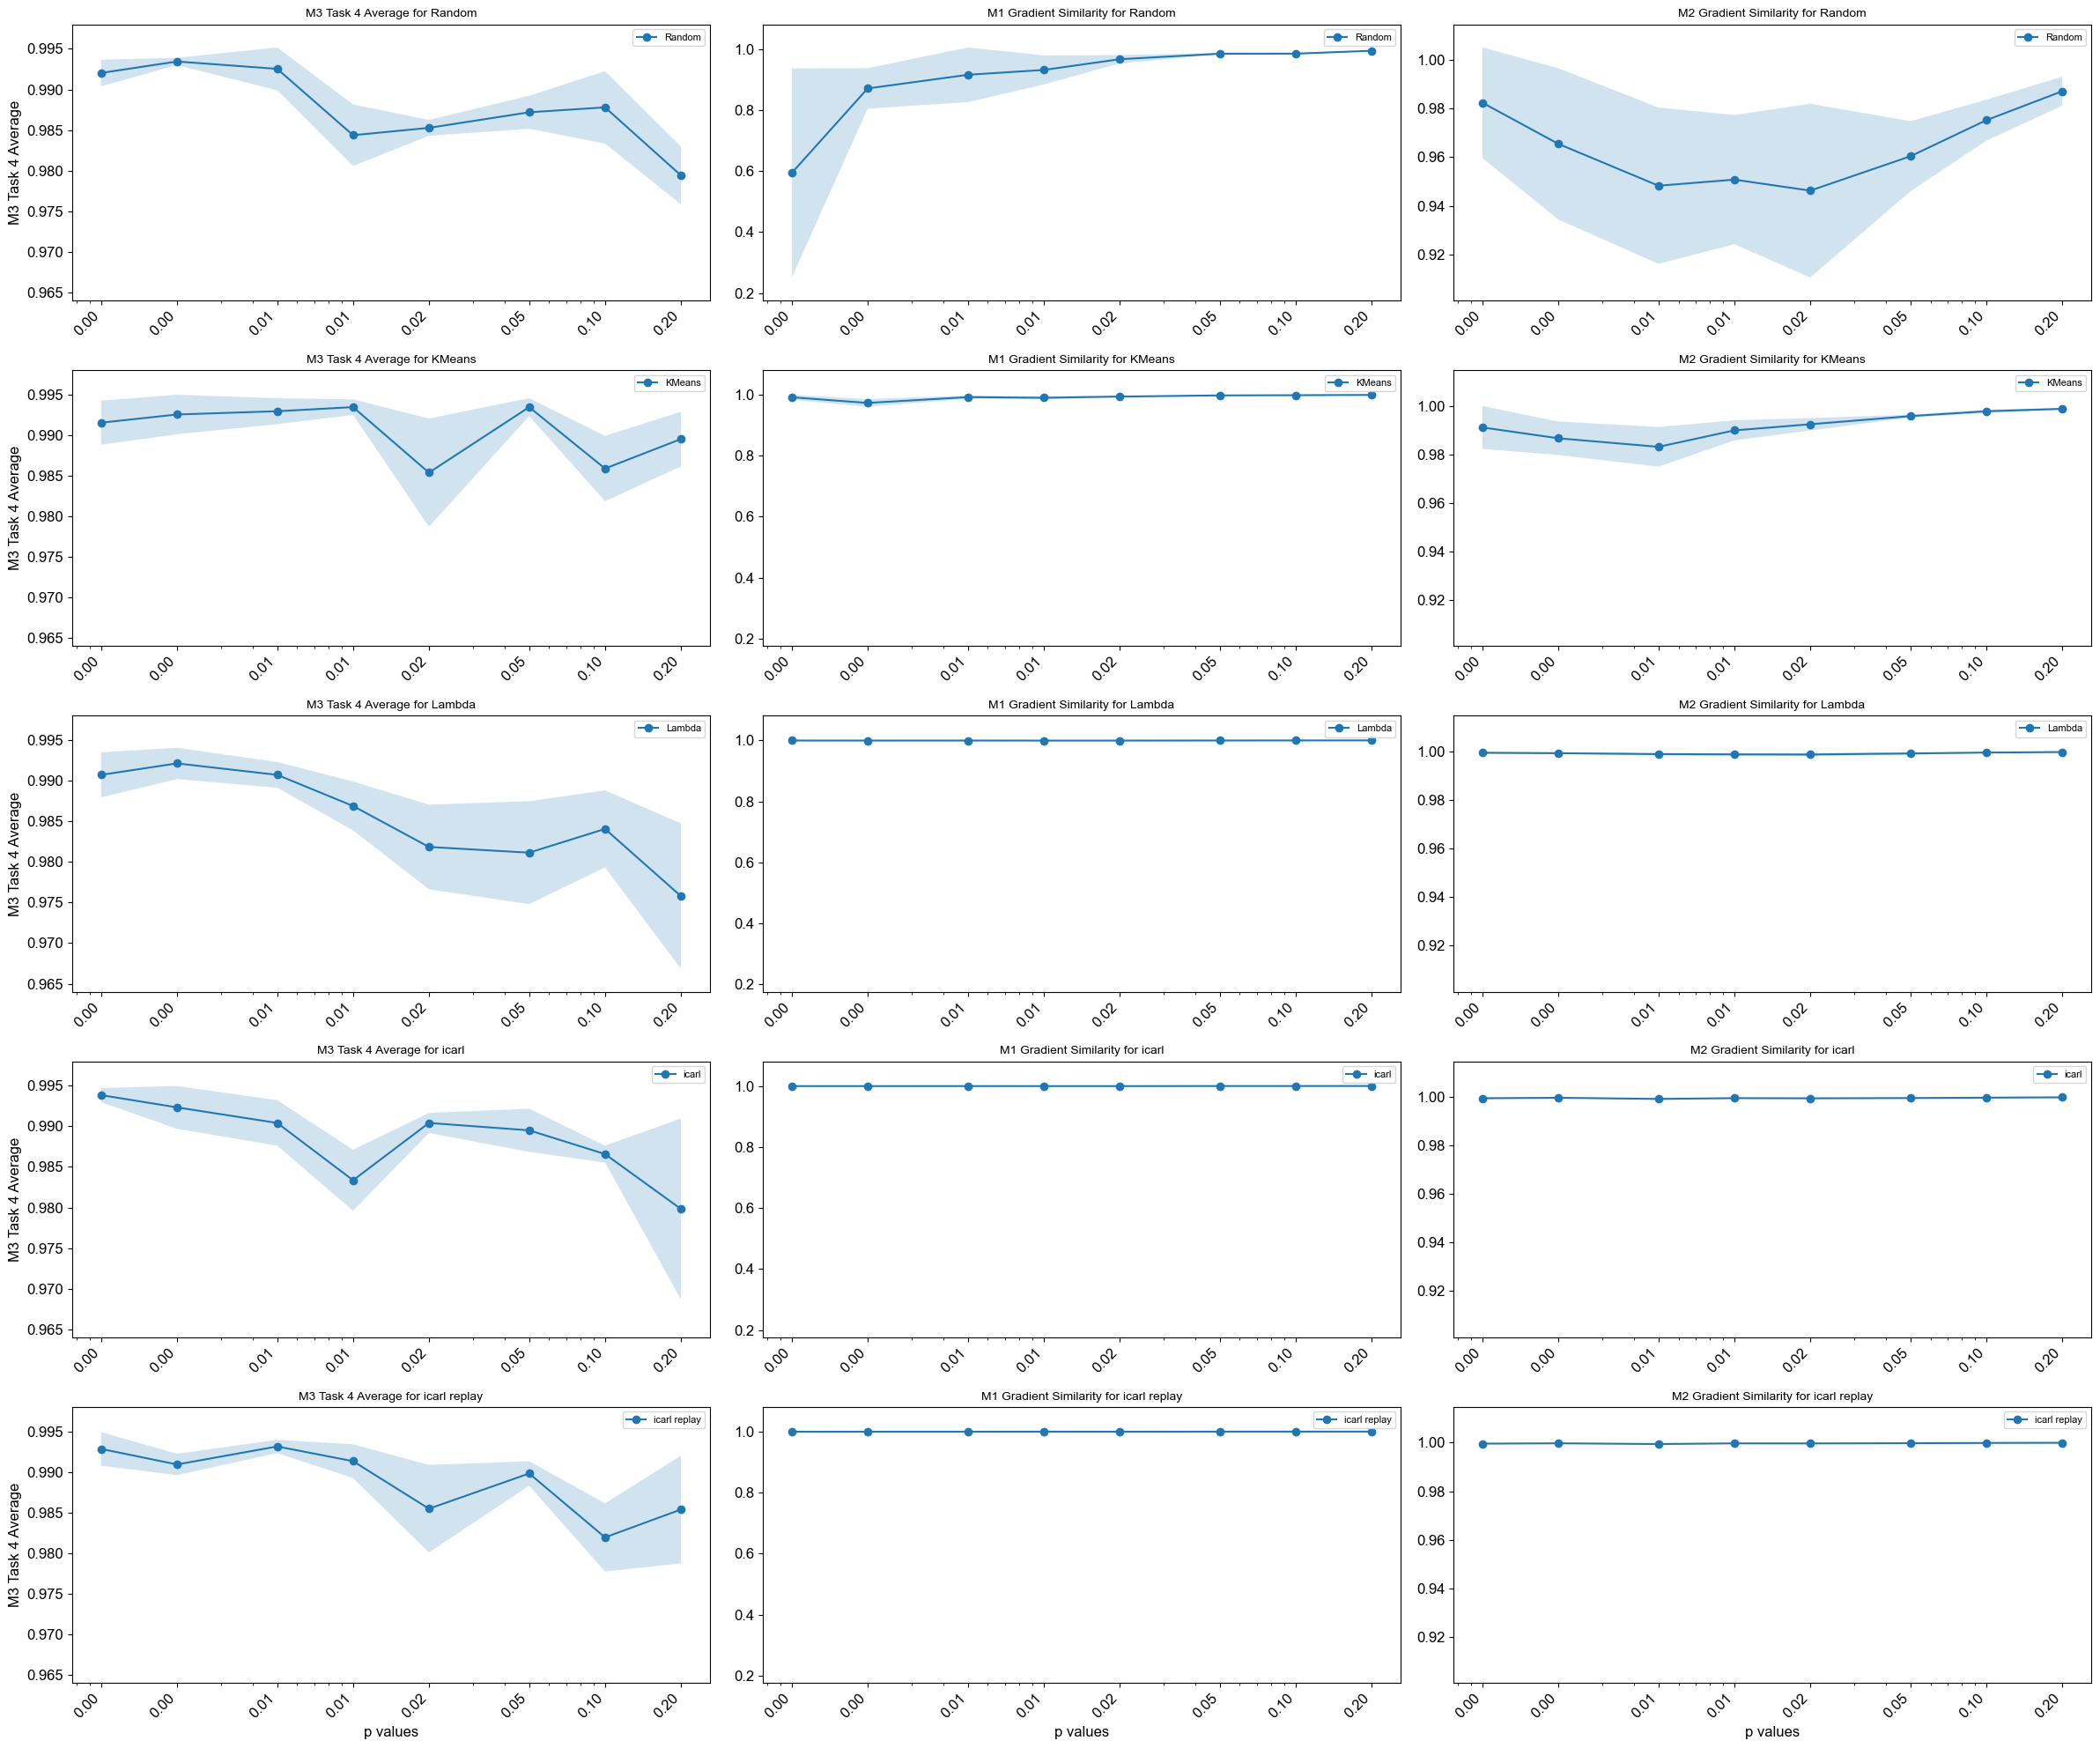

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_all_metrics_normalize_axis(aggregated_results, dataset_name):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    methods = aggregated_results['method'].unique()
    p_vals = sorted(aggregated_results['p'].unique())
    
    num_methods = len(methods)
    fig, axs = plt.subplots(num_methods, 3, figsize=(24, 4*num_methods))
    
    metrics = ['M3_task4', 'M1_grad_sim', 'M2_grad_sim']
    titles = ['M3 Task 4 Average', 'M1 Gradient Similarity', 'M2 Gradient Similarity']
    
    # Find global min and max for each metric, including std
    y_limits = {}
    for metric in metrics:
        min_val = (aggregated_results[f'{metric}_avg'] - aggregated_results[f'{metric}_std']).min()
        max_val = (aggregated_results[f'{metric}_avg'] + aggregated_results[f'{metric}_std']).max()
        y_range = max_val - min_val
        y_limits[metric] = (min_val - 0.1 * y_range, max_val + 0.1 * y_range)
    
    for method_index, method in enumerate(methods):
        method_data = aggregated_results[aggregated_results['method'] == method]
        
        for col, (metric, title) in enumerate(zip(metrics, titles)):
            if num_methods == 1:
                ax = axs[col]
            else:
                ax = axs[method_index, col]
            
            avg_values = [method_data[method_data['p'] == p][f'{metric}_avg'].values[0] for p in p_vals]
            std_values = [method_data[method_data['p'] == p][f'{metric}_std'].values[0] for p in p_vals]
            
            ax.plot(p_vals, avg_values, marker='o', label=method)
            ax.fill_between(p_vals, 
                            np.array(avg_values) - np.array(std_values), 
                            np.array(avg_values) + np.array(std_values), 
                            alpha=0.2)
            
            ax.set_xscale('log')
            ax.set_title(f'{title} for {method}', fontsize=10)
            ax.legend(fontsize=8)
            
            ax.set_xticks(p_vals)
            ax.set_xticklabels([f'{p:.2f}' for p in p_vals], rotation=45, ha='right')
            
            # Set y-axis limits to be the same for all methods within each metric
            ax.set_ylim(y_limits[metric])
            
            if method_index == num_methods - 1:  # Last row
                ax.set_xlabel('p values')
            
            if col == 0:  # First column
                ax.set_ylabel(title)
    
    plt.tight_layout()
    plt.savefig(f'{result_dir}/all_metrics_vs_p_subplots.png')
    plt.show()

plot_all_metrics_normalize_axis(aggregated_results, 'dataset_name')

TypeError: list indices must be integers or slices, not float

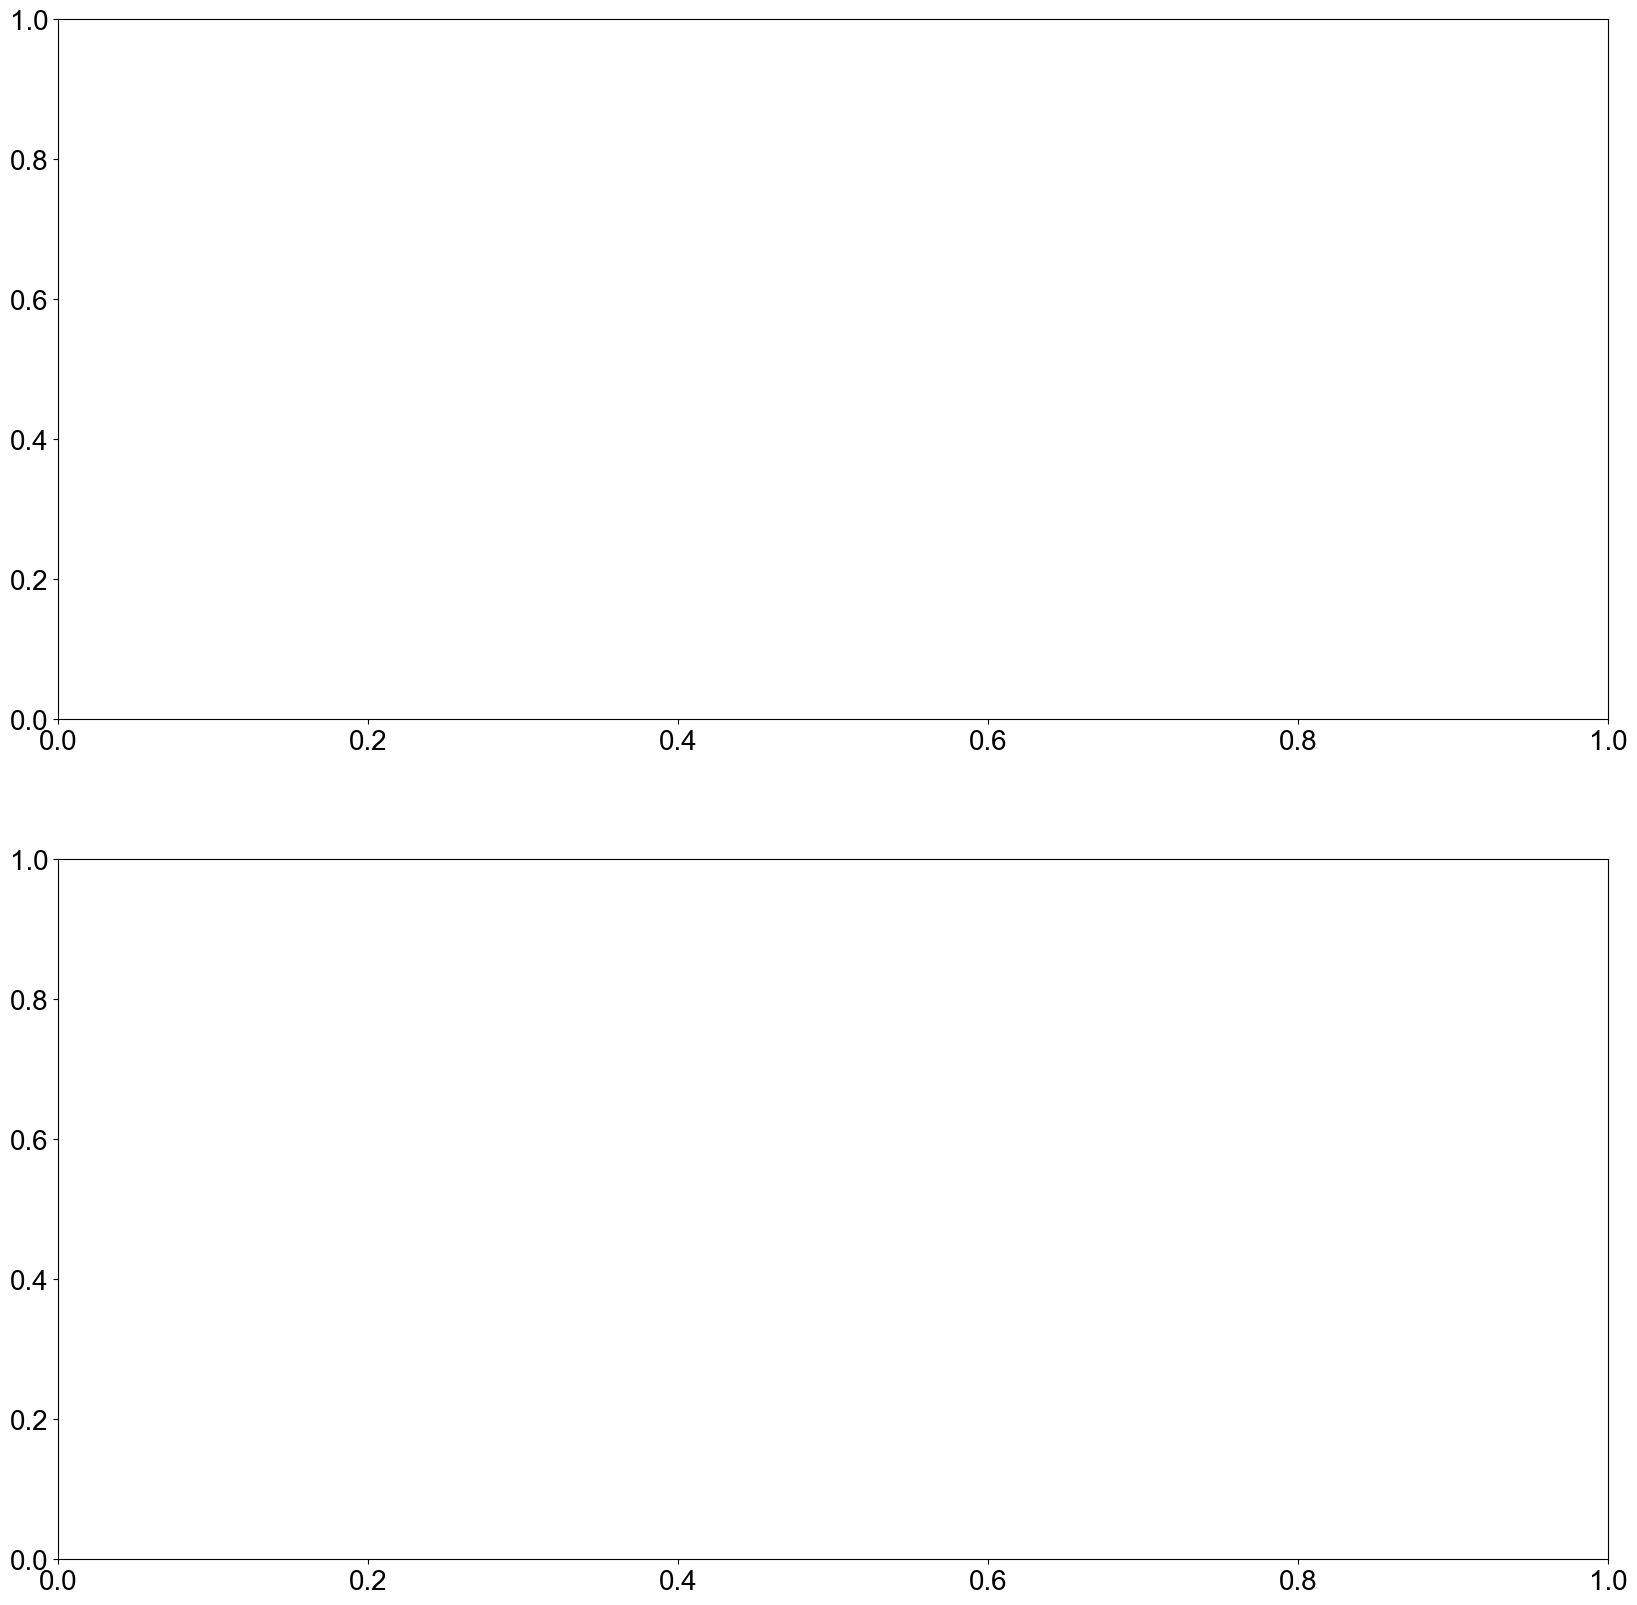

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os

def scatterplot_grad_dist(aggregated_results, dataset_name, p_indices=None):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    
    methods = aggregated_results['method'].unique()
    p_vals = sorted(aggregated_results['p'].unique())
    
    if p_indices is None:
        p_indices = range(len(p_vals))
    
    fig, axs = plt.subplots(len(p_indices), 1, figsize=(20, 10*len(p_indices)))
    
    for i, p_index in enumerate(p_indices):
        if len(p_indices) == 1:
            ax = axs
        else:
            ax = axs[i]
        
        p_val = p_vals[p_index]
        p_data = aggregated_results[aggregated_results['p'] == p_val]
        
        for method in methods:
            method_data = p_data[p_data['method'] == method]
            
            acc = method_data['M3_task4_avg'].values[0]
            grad_sim_m1 = method_data['M1_grad_sim_avg'].values[0]
            grad_sim_m2 = method_data['M2_grad_sim_avg'].values[0]
            grad_var_m1 = method_data['M1_grad_sim_std'].values[0]
            grad_var_m2 = method_data['M2_grad_sim_std'].values[0]
            
            ax.scatter(acc, grad_sim_m1, label=f'{method} (M1)')
            ax.errorbar(acc, grad_sim_m1, yerr=grad_var_m1, fmt='none', capsize=5)
            
            ax.scatter(acc, grad_sim_m2, label=f'{method} (M2)')
            ax.errorbar(acc, grad_sim_m2, yerr=grad_var_m2, fmt='none', capsize=5)
        
        ax.set_title(f'Gradient Similarity vs Downstream Accuracy Scatterplot for p = {p_val:.2f}')
        ax.set_xlim(0.2, 1)
        ax.set_ylim(0, 1.1)
        if i == len(p_indices) - 1:
            ax.set_xlabel('Downstream Accuracy')
        ax.set_ylabel('Gradient Similarity')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(f'{result_dir}/scatterplot_indiv.png')
    plt.show()

# Example usage:
scatterplot_grad_dist(aggregated_results, 'your_dataset_name', p_indices=[0.01, 0.02])

In [ ]:
def plot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type,
                   together = False):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
    
    if together: # just create 1 subplot for everything
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    num_methods = len(method_arr)
    if not together:
        fig, axs = plt.subplots(num_methods, 2, figsize=(20, 4*num_methods))  # Adjust subplot size as needed

    for method_index, method in enumerate(method_arr):
        #if not together:
        #    fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Adjust subplot size as needed
        
        if (num_methods == 1) or together:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs
        else:
            ax = axs[method_index]
        
        method_name = method_names[method_index]

        # load accuracies
        acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
        # acc_block is (p_val x num_tasks) of downstream acc performance
        if downstream_acc_type == 'last':
            acc_arr = acc_block[:, -1]
        elif downstream_acc_type == 'avg':
            acc_arr = np.mean(acc_block, axis = -1)
        else:
            print('invalid downstream acc type')
            assert False

        # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
        grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

        avg_over_grad_files = np.mean(grad_block, axis = -1)
        avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

        if variance_type == 'dataset':
            avg_grad_block = avg_over_tasks[:,:,0]
            # avg over runs
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'weight':
            avg_grad_block = avg_over_tasks[:,0,:]
            # avg over ideal models
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'all':
            grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
            grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)
        
        ax[1].set_xlim(0, 1)
        ax[0].plot(p_vals, grad_dists, marker='o', label = method_name)
        if not together:
            ax[0].fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
        #ax[0].set_xlabel('p values')
        #ax[0].set_ylabel('Gradient distance')
        ax[0].set_xscale('log')
        if not together:
            ax[0].set_title(f'{metric_name} for {method_name}')

        ax[1].plot(acc_arr, grad_dists, marker='o', label = method_name)
        if not together:
            ax[1].fill_between(acc_arr, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
        #ax[1].set_xlabel('Downstream accuracy')
        #ax[1].set_ylabel('Gradient distance')
        if not together:
            ax[1].set_title(f'{metric_name} for {method_name}')
            
        if method_index == len(method_arr) -1: # plot for last row
            ax[0].set_xlabel('p values')
            ax[1].set_xlabel('Downstream accuracy')
        elif method_index == 0:
            ax[0].set_ylabel('Gradient distance')
            
            
    
    # save_path = f'{save_path}/task_{task}/{fig_name_prefix}'
    # os.makedirs(save_path, exist_ok=True)

    # plt.tight_layout()
    # if plot_acc: # plotting against accuracy
    #     img_name = f'{save_path}/{dataset_name}_acc.png'
    # else: # plotting against p_values
    #     img_name = f'{save_path}/{dataset_name}_p.png'
    # plt.savefig(img_name)
    if not together:
        plt.tight_layout()
        plt.savefig(f'{result_dir}/mem_indiv.png')
        plt.show()
    else:
        axs[0].legend()
        axs[1].legend()
        
        axs[0].set_title(f'{metric_name} vs P-value')
        axs[1].set_title(f'{metric_name} vs Downstream Accuracy')
        plt.tight_layout()
        plt.savefig(f'{result_dir}/mem_comp.png')
        plt.show()

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['class_balanced']
method_names = ["Class-Balanced Reservoir Sampling"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
together = True

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               together = together)

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", 'Kmeans']
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
together = True

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               together = together)

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", "K-means"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
together = False

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               together = together)

In [ ]:
def scatterplot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type,
                   p_indices):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
        
    fig, axs = plt.subplots(len(p_indices), 1, figsize=(20, 10*len(p_indices)))
    
    #plt.figure(figsize = (20, 10))
    
    num_methods = len(method_arr)
    
    for i, p_index in enumerate(p_indices):
        
        if (len(p_indices) == 1):
            ax = axs
        else:
            ax = axs[i]
        
    
        for method_index, method in enumerate(method_arr):

            method_name = method_names[method_index]

            acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
            # acc_block is (p_val x num_tasks) of downstream acc performance
            if downstream_acc_type == 'last':
                acc_arr = acc_block[:, -1]
            elif downstream_acc_type == 'avg':
                acc_arr = np.mean(acc_block, axis = -1)
            else:
                print('invalid downstream acc type')
                assert False

            # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
            grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

            avg_over_grad_files = np.mean(grad_block, axis = -1)
            avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

            if variance_type == 'dataset':
                avg_grad_block = avg_over_tasks[:,:,0]
                # avg over runs
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'weight':
                avg_grad_block = avg_over_tasks[:,0,:]
                # avg over ideal models
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'all':
                grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
                grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)

            grad_pt = grad_dists[p_index]
            grad_var = grad_stds[p_index]
            acc = acc_arr[p_index]
            ax.scatter(acc, grad_pt, label = method_name)
            ax.errorbar(acc, grad_pt, yerr = grad_var) 
            ax.set_title(f'Gradient Similarity vs Downstream Accuracy Scatterplot for p = {p_vals[p_index]}')
            ax.set_xlim(0.2, 1)
            ax.set_ylim(0, 1.1)
            if i == len(p_indices)-1:
                ax.set_xlabel('Downstream Accuracy')
            ax.set_ylabel('Gradient Similarity')
            ax.legend()
            
    #plt.xlim(0.2, 1)
    #plt.ylim(0, 1.1)
    #plt.suptitle(f'Gradient Similarity vs Downstream Accuracy for Memory Selection Methods')
    #plt.ylabel('Gradient Similarity')
    #plt.xlabel('Downstream Accuracy')
    #plt.legend()
    plt.tight_layout()
    plt.savefig(f'{result_dir}/scatterplot_indiv.png')
    plt.show()

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", "K-means"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
p_indices = [0, 3, 6, 8]

scatterplot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               p_indices = p_indices)

In [ ]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def batch_scatterplot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type,
                   p_indices,
                   plot_ellipse):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
    
    plt.figure(figsize = (20, 10))
    ax = plt.gca()
    
    num_methods = len(method_arr)
    
    for i, p_index in enumerate(p_indices):
        
        grad_pts = np.zeros(num_methods)
        grad_vars = np.zeros(num_methods)
        accs = np.zeros(num_methods)
        
        for method_index, method in enumerate(method_arr):

            method_name = method_names[method_index]

            acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
            # acc_block is (p_val x num_tasks) of downstream acc performance
            if downstream_acc_type == 'last':
                acc_arr = acc_block[:, -1]
            elif downstream_acc_type == 'avg':
                acc_arr = np.mean(acc_block, axis = -1)
            else:
                print('invalid downstream acc type')
                assert False

            # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
            grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

            avg_over_grad_files = np.mean(grad_block, axis = -1)
            avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

            if variance_type == 'dataset':
                avg_grad_block = avg_over_tasks[:,:,0]
                # avg over runs
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'weight':
                avg_grad_block = avg_over_tasks[:,0,:]
                # avg over ideal models
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'all':
                grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
                grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)

            grad_pts[method_index] = grad_dists[p_index]
            grad_vars[method_index] = grad_stds[p_index]
            accs[method_index] = acc_arr[p_index]
        
        obj = ax.scatter(accs, grad_pts, label = f'p = {p_vals[p_index]}')
        if plot_ellipse:
            confidence_ellipse(accs, grad_pts, ax, n_std=1.0, edgecolor=obj.get_ec())
        else:
            plt.errorbar(accs, grad_pts, yerr = grad_vars, ls = 'none') 

    plt.xlim(0.2, 1)
    plt.ylim(0, 1.1)
    plt.title(f'Gradient Similarity vs Downstream Accuracy for Memory Selection Methods for Multiple P-values')
    plt.ylabel('Gradient Similarity')
    plt.xlabel('Downstream Accuracy')
    plt.legend(loc = 'lower left')
    if plot_ellipse:
        plt.savefig(f'{result_dir}/batch_scatterplot_ellipse.png')
    else:
        plt.savefig(f'{result_dir}/batch_scatterplot.png')
    plt.show()

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", "K-means"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
p_indices = [0, 1, 3, 5, 6, 8]
plot_ellipse = False

batch_scatterplot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               p_indices = p_indices,
               plot_ellipse = plot_ellipse)

In [ ]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", "K-means"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
p_indices = [0, 1, 3, 5, 6, 8]
plot_ellipse = True

batch_scatterplot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               p_indices = p_indices,
               plot_ellipse = plot_ellipse)